In [71]:
# from google.colab import drive
# drive.mount('/content/drive')

First, we will load the datasets

In [5]:
import pandas as pd

reports = pd.read_csv("C:/Users/34649/Desktop/UNIVERSIDAD/CUARTO/Taxonomy Classification of AI Incidents/backup-20230925101051/mongodump/reports.csv")
incidents = pd.read_csv("C:/Users/34649/Desktop/UNIVERSIDAD/CUARTO/Taxonomy Classification of AI Incidents/backup-20230925101051/mongodump/incidents.csv")


In [73]:
reports.head(2)

_id  incident_id               authors  \
0  ObjectId(5d34b8c29ced494f010ed45a)          NaN     ["Alistair Barr"]   
1  ObjectId(5d34b8c29ced494f010ed461)          NaN  ["Sapna Maheshwari"]   

  date_downloaded date_modified date_published date_submitted  \
0      2019-04-13    2020-06-14     2015-05-19     2019-06-01   
1      2019-04-13    2020-06-14     2018-04-26     2019-06-01   

                                         description  epoch_date_downloaded  \
0  Child and consumer advocacy groups complained ...             1555113600   
1  Parents will be able to handpick the channels ...             1555113600   

   epoch_date_modified  ...  \
0           1592092800  ...   
1           1592092800  ...   

                                           image_url  language ref_number  \
0  http://si.wsj.net/public/resources/images/BN-I...        en        NaN   
1  https://static01.nyt.com/images/2017/11/07/bus...        en        NaN   

  report_number  source_domain            submitters  \
0             1  blogs.wsj.com  ["Roman Yampolskiy"]   
1             8    nytimes.com  ["Roman Yampolskiy"]   

                                                text  \
0  Child and consumer advocacy groups complained ...   
1  YouTube Kids, which has been criticized for in...   

                                               title  \
0  Google’s YouTube Kids App Criticized for ‘Inap...   
1  YouTube Kids, Criticized for Content, Introduc...   

                                                 url tags  
0  https://blogs.wsj.com/digits/2015/05/19/google...   []  
1  https://www.nytimes.com/2018/04/25/business/me...   []  

[2 rows x 22 columns]

In [74]:
print('The reports dataset contains', len(reports), 'rows')

The reports dataset contains 3028 rows


In [75]:
incidents.head(2)

_id  incident_id        date  \
0  ObjectId(625763de343edc875fe63a15)           23  2017-11-08   
1  ObjectId(625763dc343edc875fe63a02)            4  2018-03-18   

                                             reports  \
0  [242,243,244,245,246,247,248,249,250,253,254,2...   
1  [629,630,631,632,633,634,635,636,637,638,639,6...   

      Alleged deployer of AI system    Alleged developer of AI system  \
0  ["navya","keolis-north-america"]  ["navya","keolis-north-america"]   
1                          ["uber"]                          ["uber"]   

             Alleged harmed or nearly harmed parties  \
0  ["navya","keolis-north-america","bus-passengers"]   
1                  ["elaine-herzberg","pedestrians"]   

                                         description  \
0  A self-driving public shuttle by Keolis North ...   
1  An Uber autonomous vehicle (AV) in autonomous ...   

                                             title  
0  Las Vegas Self-Driving Bus Involved in Accident  
1             Uber AV Killed Pedestrian in Arizona

In [76]:
print('The incidents dataset contains', len(incidents), 'rows')

The incidents dataset contains 556 rows


As we can see, the reports dataset is longer than the incidents one, as the incidents one is a reduced version.

We will now drop the columns of the reports dataset that we do not need.

In [77]:
reports.drop(columns=["_id","incident_id","authors","date_downloaded","date_modified","date_published","date_submitted","epoch_date_downloaded","epoch_date_modified","epoch_date_published","epoch_date_submitted","image_url","language","ref_number","report_number","source_domain","submitters","url","tags"], inplace=True)

Let's visualize the reduced reports dataset:

In [78]:
reports.head(5)

description  \
0  Child and consumer advocacy groups complained ...   
1  Parents will be able to handpick the channels ...   
2  Children's search terms on YouTube are still a...   
3  Investigators found several unsuitable videos ...   
4  YouTube removed videos from conspiracy theoris...   

                                                text  \
0  Child and consumer advocacy groups complained ...   
1  YouTube Kids, which has been criticized for in...   
2  Video still of a reproduced version of Minnie ...   
3  Google-owned YouTube has apologised again afte...   
4  Children were able to watch David Icke's consp...   

                                               title  
0  Google’s YouTube Kids App Criticized for ‘Inap...  
1  YouTube Kids, Criticized for Content, Introduc...  
2  Children's YouTube is still churning out blood...  
3  YouTube Kids app is STILL showing disturbing v...  
4  YouTube suggested conspiracy videos to childre...

Check there is not missing values

In [79]:
missing_values = reports.isnull().sum()
print("Missing values in each column: \n", missing_values)

Missing values in each column: 
 description    1011
text              0
title             3
dtype: int64


We will be using the column TEXT, so let's keep the data as it is for now.

In order to clean the text and keep only the useful semantic content, we will use the NLTK library.

In [80]:
# Let's import the necessary libraries for NLTK preprocessing
import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re

from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize

from nltk.stem import WordNetLemmatizer

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34649\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\34649\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\34649\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We will now create a function that does the whole preprocessing using NLTK for us. This function will do the following tasks:
1. **Text Wrangling:** we will remove all HTML tags, URLs, and expand any contraction in the text as they do not add any relevant information.
2. **Tokenization:** we will separate the text into different tokens, including words, commas, etc.
3. **Homogenization:** we will transform all token into lower-cased, remove all non-alphanumeric characters (periods, question marks, etc) and then use the lemmatizer method to preserve the roots of the words (remove word terminations for simplicity)
4. **Cleaning:** we will remove words that do not carry any semantic content (articles, pronouns, etc)

In [81]:
def prepare_data(text):
# This function does the whole preparation of the data for us

    # Remove HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()

    # Remove URLs
    text = re.sub(r'https://\S+|www\.\S+', '', text)

    # Expand contractions
    text = contractions.fix(text)

    # Tokenize at sentence and word level
    review_tokens_sent = [wordpunct_tokenize(sent) for sent in sent_tokenize(text)]
    review_tokens = [token for sent in review_tokens_sent for token in sent]

    # Filter tokens
    review_tokens_filtered = [token.lower() for token in review_tokens if token.isalnum()]

    # Stem and lemmatize tokens
    wnl = WordNetLemmatizer()
    lemmatized_review = [wnl.lemmatize(token) for token in review_tokens_filtered]

    # Remove stopwords
    stopwords_en = set(stopwords.words('english'))
    clean_review = [token for token in lemmatized_review if token not in stopwords_en]

    return clean_review

Let's apply our function to create a clean review column from our text column in the reports dataset.

In [82]:
# We use the function above to create a clean review column of the prepared data
reports['clean_review'] = reports['text'].apply(prepare_data)

#Let's visualize the new column 'clean_review'
reports.head(5)

KeyboardInterrupt: 

To see the words that appear with more frequency, let's create a function to show a wordcloud.

In [84]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_clean_review(data):
    # Create a new DataFrame where each word is in a separate row
    words = data.explode("clean_review")

    # Flatten nested lists of strings
    words = words.apply(lambda x: [y if isinstance(y, str) else "" for y in x])

    # Count the frequency of each word
    word_counts = Counter(words["clean_review"].tolist())

    # Create a word cloud
    wc = WordCloud(background_color="white", width=800, height=400,
                   max_words=200, colormap="viridis").generate_from_frequencies(word_counts)

    # Visualize the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Wordcloud of our clean_review column:

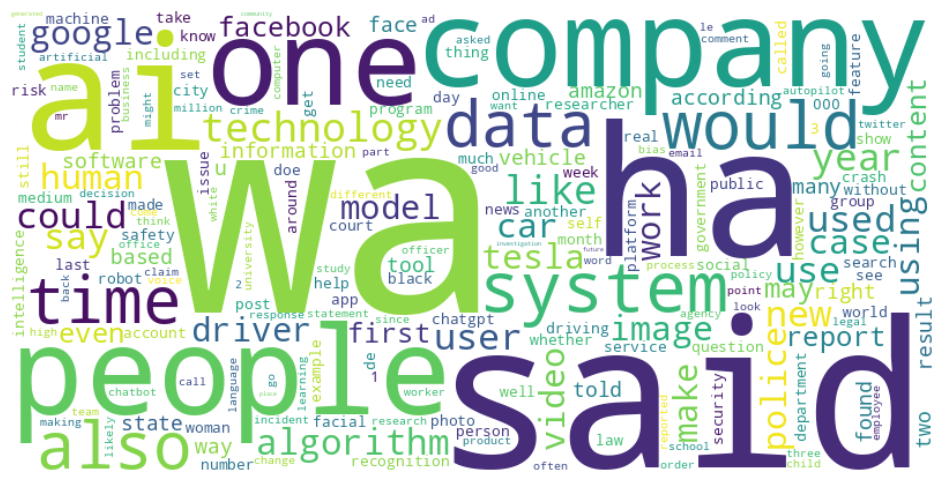

In [ ]:
visualize_clean_review(reports)

Furthermore, we will create a corpus made up of every clean review.

In [ ]:
corpus = []
for review in reports['clean_review']:
  corpus.append(review)

print('Number of documents in corpus: '+str(len(corpus)))
print('\n============= First review =============')
print(corpus[0])

Number of documents in corpus: 3028

============= First review =============
['child', 'consumer', 'advocacy', 'group', 'complained', 'federal', 'trade', 'commission', 'tuesday', 'google', 'new', 'youtube', 'kid', 'app', 'contains', 'inappropriate', 'content', 'including', 'explicit', 'sexual', 'language', 'joke', 'pedophilia', 'google', 'launched', 'app', 'young', 'child', 'february', 'saying', 'available', 'video', 'narrowed', 'content', 'appropriate', 'kid']


We can calculate the average number of tokens per review:

In [ ]:
import numpy as np

# Calculate the average number of tokens per review
avg_tokens_per_review = np.mean([len(review) for review in corpus])
print(f"Average number of tokens per review: {avg_tokens_per_review:.2f}")

Average number of tokens per review: 454.84


Let's visualize the number of tokens per review in a histogram

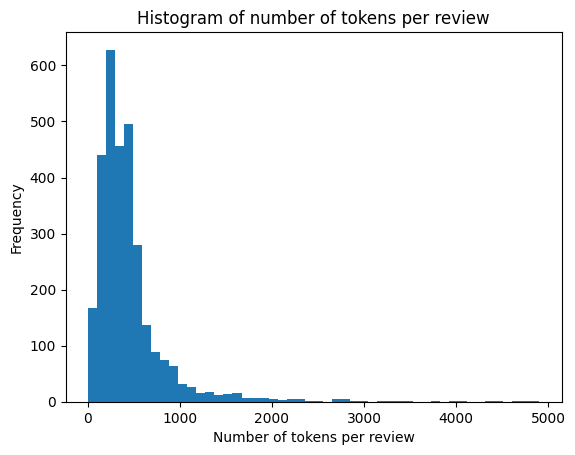

In [ ]:
# Plot the histogram of the number of tokens per review
plt.hist([len(review) for review in corpus], bins=50)
plt.xlabel("Number of tokens per review")
plt.ylabel("Frequency")
plt.title("Histogram of number of tokens per review")
plt.show()

Now, we will analyze the tokens that appear next to each other with high frequency, and join them for simplicity. This is called **N-gram replacement**.

In [ ]:
from gensim.models.phrases import Phrases

phrase_model = Phrases(corpus, min_count=2, threshold=20)

print('\n============= First review in corpus =============')
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print('\n============= First review after N-gram replacement =============')
print(corpus[0])


============= First review in corpus =============
['child', 'consumer', 'advocacy', 'group', 'complained', 'federal', 'trade', 'commission', 'tuesday', 'google', 'new', 'youtube', 'kid', 'app', 'contains', 'inappropriate', 'content', 'including', 'explicit', 'sexual', 'language', 'joke', 'pedophilia', 'google', 'launched', 'app', 'young', 'child', 'february', 'saying', 'available', 'video', 'narrowed', 'content', 'appropriate', 'kid']

============= First review after N-gram replacement =============
['child', 'consumer_advocacy', 'group', 'complained', 'federal_trade', 'commission', 'tuesday', 'google', 'new', 'youtube_kid', 'app', 'contains', 'inappropriate_content', 'including', 'explicit_sexual', 'language', 'joke', 'pedophilia', 'google', 'launched', 'app', 'young_child', 'february', 'saying', 'available', 'video', 'narrowed', 'content', 'appropriate', 'kid']


We will now save the fully processed corpus into a text file for later use

In [ ]:
reports['clean_review'] = corpus

with open("lemmas_clean.txt", 'w', encoding='utf-8') as fout:
  for el in reports['clean_review'].values.tolist():
    fout.write(' '.join(el) + '\n')

Now, to work with this corpus, we need to vectorize all the documents. First, we will create a dictionary containing all tokens in the corpus and assign an index to each of them.

In [ ]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The positive dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The positive dictionary contains 66720 terms
First terms in the dictionary:
0 : app
1 : appropriate
2 : available
3 : child
4 : commission
5 : complained
6 : consumer_advocacy
7 : contains
8 : content
9 : explicit_sexual


Then, we will create a dataframe with the token word and the total number of occurrences throughout all documents.

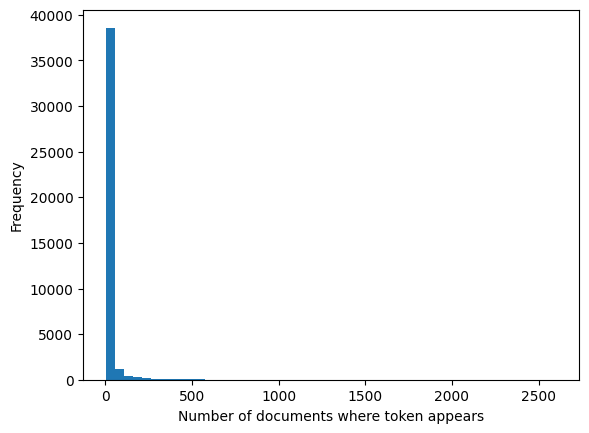

             token  token_id  ndocs
0           people        74   2604
1               11        28   2390
2           animal       126   2049
3             also        33   2005
4             lack        60   1917
...            ...       ...    ...
41064       starry     28687      2
41065          cận     61855      2
41066      flatten     61807      2
41067        cầyou     61854      2
41068  campaigning     35867      2

[41069 rows x 3 columns]


In [ ]:
# We create the dataframe
token_counts = pd.DataFrame(D.token2id.items(), columns=['token', 'token_id'])
token_counts['ndocs'] = D.dfs.values()

# We sort in descending order
token_counts = token_counts.sort_values('ndocs', ascending=False).reset_index(drop=True)

# We discard tokens that appear in just one doc
token_counts = token_counts[token_counts.ndocs > 1]

# Define most and least common tokens
most_common_tokens = token_counts.head()
less_common_tokens = token_counts.tail()

# PLot the histogram
plt.hist(token_counts['ndocs'], bins=50)
plt.xlabel('Number of documents where token appears')
plt.ylabel('Frequency')
plt.show()

print(token_counts)

In addition, we will remove those tokens that appear just once throughout all documents because they are not very useful for us.

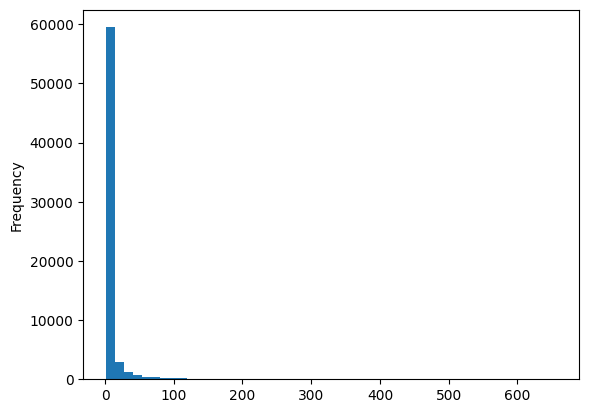

In [ ]:
token_ndocs = pd.DataFrame({
    'token': [D[id] for id in range(n_tokens)],
    'ndocs': [D.dfs[id] for id in range(n_tokens)]
})

token_ndocs = token_ndocs.sort_values(by='ndocs', ascending=False)

unique_ndocs = token_ndocs['ndocs'].value_counts()
one_doc_tokens = unique_ndocs[unique_ndocs == 1].index
token_ndocs = token_ndocs[~token_ndocs['ndocs'].isin(one_doc_tokens)]

most_common = token_ndocs.iloc[0]['token']
least_common = token_ndocs.iloc[-1]['token']

# Plot
token_ndocs['ndocs'].plot(kind='hist', bins=50)
plt.show()

We will now filter out those tokens that have very few appearances and too many appearances, as they are probably not very informative or could be typos.

In [ ]:
no_below = 4 # Minimum number of documents to keep a term in the dictionary
no_above = .90 # Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 23564 terms


In [ ]:
print('The original dictionary contains', len(Dictionary(corpus)), 'terms') # length of original dictionary
print('The new dictionary contains', n_tokens, 'terms') # length of new filtered dictionary

The original dictionary contains 66720 terms
The new dictionary contains 23564 terms


Once we have our new dictionary, we can proceed with **Bag-Of-Words** representation. To begin with, we will obtain a numerical representation of our corpus and transform any list of tokens into a list of tuples. It can be seen as a vector with tuples (id, n)

In [ ]:
reviews_bow = [D.doc2bow(doc) for doc in corpus]

n_review = 1000
print('============= Review (lemmas) =============')
print(' '.join(corpus[n_review]))

print('\n============= Sparse vector representation =============')
print(reviews_bow[n_review])

print('\n============= Word counts for the review =============')
print(list(map(lambda x: (D[x[0]], x[1]), reviews_bow[n_review])))

============= Review (lemmas) =============
turnbull_government robo_debt program involves enforcement illegal debt case inflated nonexistent former member administrative_appeal tribunal ha said scathing indictment program contained academic_paper prof terry carney also accuses centrelink failing defend legality debt aat suggests tribunal set_aside debt agency ha proved amount correct criticism ha echoed national social security right network welfare right centre warned case false debt routinely challenged reduced completely wiped tribunal centrelink forced wipe change one six robo_debt read carney explained robo_debt program calculates welfare_recipient income average fortnightly_period rather discovering actual income every fortnightly_period writes proper basis calculating_debt carney said centrelink asks payment alleged_debt evidence disprove vulnerable alleged debtor simply throw hand assume centrelink know really debt seek pay quickly_possible said welfare_agency even_though repo

Furthermore, we can proceed by creating our **TF-IDF model**.

The **TF part** (Term Frequency) measures how frequently each word appears in a document. The **IDF part** (Inverse Document Frequency) measures how rare it is for a word to appear, giving higher scores for words that appear in fewer documents.

In [ ]:
from gensim.models import TfidfModel

tfidf = TfidfModel(reviews_bow, dictionary=D)
reviews_tfidf = tfidf[reviews_bow]

In [ ]:
n_project = 1000
print('============= TFIDF representation for the project =============')
print(reviews_tfidf[n_review])

print('\n============= TFIDF applying the transformation only to the document =============')
print(tfidf[reviews_bow[n_review]])

============= TFIDF representation for the project =============
[(31, 0.026686686342527684), (33, 0.008694817988721584), (50, 0.01125075471070997), (74, 0.0058084221434818615), (78, 0.01570012171151246), (81, 0.028265926542148438), (82, 0.041889067880961195), (85, 0.03528518011110766), (89, 0.01533091084572897), (98, 0.015676819470040834), (102, 0.0014346176138649192), (104, 0.008613948846096418), (110, 0.02158250812848573), (133, 0.03982054091147551), (182, 0.017797695693929663), (183, 0.013348391543176678), (186, 0.024430427611533873), (193, 0.023165669572768766), (194, 0.010641339122671354), (236, 0.017988799035128476), (245, 0.015394100436900354), (254, 0.0074282686840489555), (255, 0.01437312109058993), (264, 0.01854021301909453), (266, 0.03479659742013424), (292, 0.01169796354377253), (293, 0.02750626682342965), (298, 0.02043878943158996), (307, 0.011453968046233965), (311, 0.049108407485057445), (312, 0.026791192872035508), (334, 0.007632971611418509), (335, 0.02784585832302072

In [ ]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename, encoding='utf-8'):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()

MyIterCorpus = IterableCorpus_fromfile('lemmas_clean.txt')
newD = Dictionary(MyIterCorpus)
no_below = 4 # Minimum number of documents to keep a term in the dictionary
no_above = .90 # Maximum proportion of documents in which a term can appear to be kept in the dictionary
newD.filter_extremes(no_below=no_below,no_above=no_above)

print('Number of documents processed:', newD.num_docs)
print('Number of elements in dictionary:', len(newD))

Number of documents processed: 3028
Number of elements in dictionary: 23564


We will proceed to do the task of **topic modeling** which consists in discovering the underlying themes or topics that exist in the collection of our reviews 's corpus. It is a way of identifying patterns of words that frequently occur together in the text and grouping them into meaningful topics.


In [ ]:
from gensim.models import LsiModel

# Initialize an LSI transformation
n_topics = 5

lsi = LsiModel(reviews_tfidf, id2word=D, num_topics=n_topics)


In [ ]:
#Display all topics including 10 most relevant tokens per topic
lsi.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.214*"tesla" + 0.144*"car" + 0.140*"ai" + 0.138*"driver" + 0.118*"google" + 0.111*"vehicle" + 0.104*"chatgpt" + 0.097*"crash" + 0.093*"facebook" + 0.092*"said"'),
 (1,
  '-0.526*"tesla" + -0.268*"driver" + -0.262*"car" + -0.230*"autopilot" + -0.219*"vehicle" + -0.210*"crash" + 0.130*"ai" + -0.125*"self_driving" + 0.121*"chatgpt" + -0.101*"driving"'),
 (2,
  '-0.495*"chatgpt" + -0.234*"chatbot" + -0.201*"tessa" + 0.199*"facebook" + -0.181*"ai" + -0.166*"neda" + -0.162*"eating_disorder" + -0.150*"tesla" + -0.146*"schwartz" + 0.141*"amazon"'),
 (3,
  '0.379*"tessa" + 0.325*"robot" + 0.309*"neda" + 0.309*"eating_disorder" + -0.243*"chatgpt" + 0.164*"amazon" + 0.145*"chatbot" + 0.139*"helpline" + -0.104*"tesla" + -0.099*"google"'),
 (4,
  '-0.435*"facebook" + -0.234*"ad" + 0.229*"robot" + 0.189*"amazon" + -0.180*"tessa" + -0.170*"tesla" + -0.156*"eating_disorder" + 0.153*"chatgpt" + -0.148*"neda" + 0.145*"shotspotter"')]

In [ ]:
lsi.show_topic(1, topn=10)

[('tesla', -0.5261822080092666),
 ('driver', -0.26806323773772595),
 ('car', -0.26185197883813033),
 ('autopilot', -0.22984435115352359),
 ('vehicle', -0.21892702415766513),
 ('crash', -0.21001974666133078),
 ('ai', 0.12968034001240675),
 ('self_driving', -0.12490287072976652),
 ('chatgpt', 0.1206418458845486),
 ('driving', -0.10055381892113636)]

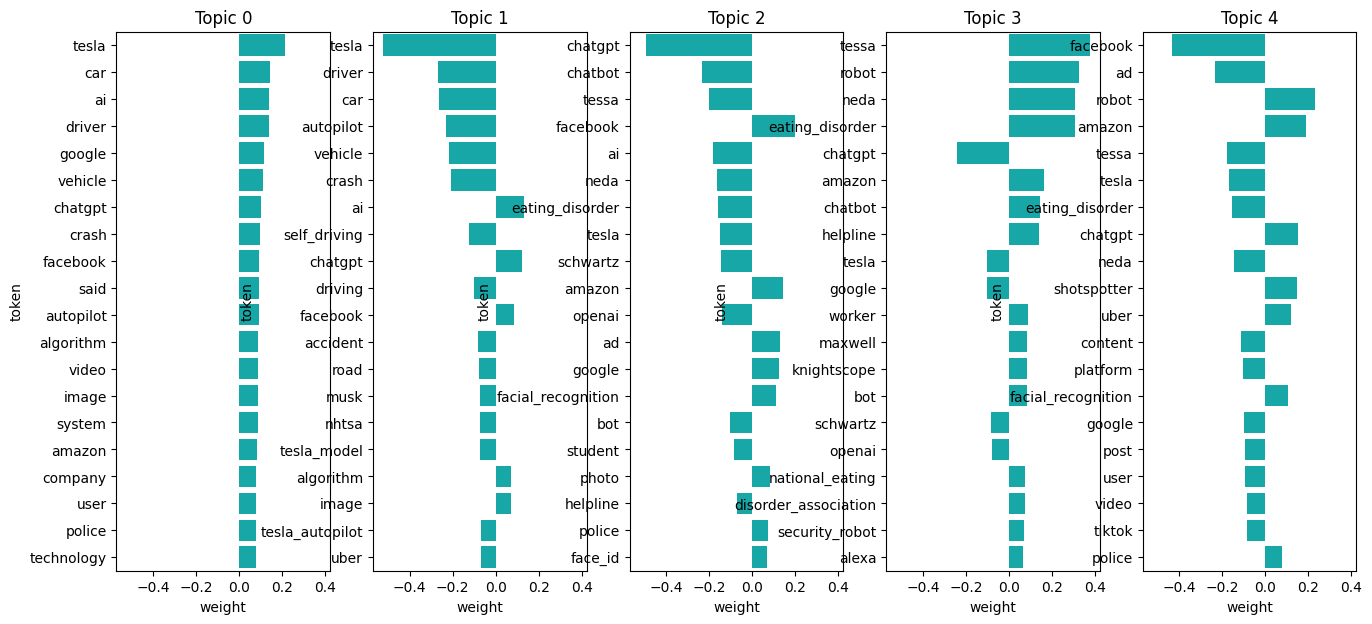

In [ ]:
import seaborn as sns

topn = 20

fig, axes = plt.subplots(1, 5, figsize=(16, 7), sharex=True)

for i in range(5):

    df = pd.DataFrame(lsi.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i])
    axes[i].set_title('Topic ' + str(i))

plt.show()

In [ ]:
print(type(reviews_tfidf))

<class 'gensim.interfaces.TransformedCorpus'>


### UNSUPERVISED METHODS
##### CLUSTERING

Adapt out tfidf matrix from gensim, so it can be used in unsupervised algorithms

In [ ]:
import gensim
# Convert Gensim TF-IDF data to a dense NumPy array
dense_tfidf_vectors = [np.array(gensim.matutils.sparse2full(vec, len(tfidf.id2word))) for vec in reviews_tfidf]
tfidf_matrix = np.array(dense_tfidf_vectors)

In [ ]:
print(tfidf_matrix.shape)
print(tfidf_matrix[0])

(3028, 23564)
[0.21186942 0.15556645 0.10223894 ... 0.         0.         0.        ]


Try different approaches:

In [ ]:
clusters = {}

In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means clustering to identify clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit_predict(tfidf_matrix)

# Get cluster assignments for each description
kmeans_assignments = kmeans.labels_
clusters["kmeans"]=kmeans_assignments

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# DBSCAN, density-based spatial clustering of applications with noise. It's a density-based clustering algorithm, unlike k-means.
from sklearn.cluster import DBSCAN

# define the model
dbscan = DBSCAN(eps=0.25, min_samples=9)

# train the model
dbscan.fit_predict(tfidf_matrix)

dbscan_assignments = dbscan.labels_
clusters["dbscan"]=dbscan_assignments

In [ ]:
# DO NOT EXECUTE
# # Gaussian Mixture Models
# from sklearn.mixture import GaussianMixture

# # define the model
# gmm = GaussianMixture(n_components=4)

# # train the model
# gmm_assignments = gmm.fit_predict(tfidf_matrix)
# clusters["gmm"]=gmm_assignments

In [ ]:
# Affinity propagation clustering

from sklearn.cluster import AffinityPropagation

# define the model
affinity = AffinityPropagation(damping=0.7)

# train the model
affinity.fit_predict(tfidf_matrix)

affinity_assignments = affinity.labels_
clusters["afinity"]=affinity_assignments

In [ ]:
# OPTICS, Ordering Points to Identify the Clustering Structure
from sklearn.cluster import OPTICS

optics_model = OPTICS(eps=0.75, min_samples=10)
optics_model.fit_predict(tfidf_matrix)
optics_assignments =optics_model.labels_
clusters["optics"]=optics_assignments


In [ ]:
# Agglomerative Hierarchy clustering algorithm
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=4)
agglomerative.fit_predict(tfidf_matrix)
agglomerative_assignments =agglomerative.labels_
clusters["agglomerative"]=agglomerative_assignments


DIFFERENT PCA APPROACHES DECOMENT AND COMMENT TO TRY DIFFERENT ONE:

In [ ]:
from sklearn.decomposition import PCA, KernelPCA

vecs = {}

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_pca = pca_vecs[:, 0]
x1_pca = pca_vecs[:, 1]
vecs["pca"] = [x0_pca,x1_pca]

# KERNEL LINEAR PCA
pca_linear = KernelPCA(n_components=2, kernel='linear' ,random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca_linear.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_linear = pca_vecs[:, 0]
x1_linear = pca_vecs[:, 1]
vecs["linear kernel"] = [x0_linear,x1_linear]

# KERNEL RBF PCA
pca_rbf = KernelPCA(n_components=2, kernel='rbf', random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca_rbf.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_rbf = pca_vecs[:, 0]
x1_rbf = pca_vecs[:, 1]
vecs["rbf kernel"] = [x0_rbf,x1_rbf]

# KERNEL POLY PCA
pca_poly = KernelPCA(n_components=2, kernel='poly',random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca_poly.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_poly = pca_vecs[:, 0]
x1_poly= pca_vecs[:, 1]
vecs["poly kernel"] = [x0_poly,x1_poly]

# KERNEL SIGMOID PCA
pca_sigmoid = KernelPCA(n_components=2, kernel='sigmoid',random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca_sigmoid.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_sigmoid = pca_vecs[:, 0]
x1_sigmoid = pca_vecs[:, 1]
vecs["sigmoid kernel"] = [x0_sigmoid,x1_sigmoid]

In [ ]:
for cluster in clusters.keys():
    for kernel in vecs.keys():

        # assign clusters and pca vectors to our dataframe
        labels = clusters[cluster]
        x0 = vecs[kernel][0]
        x1 = vecs[kernel][1]
        df = pd.DataFrame(list(zip(labels, x0, x1)),
               columns =['cluster', 'x0', 'x1'])
        # set image size
        plt.figure(figsize=(12, 7))
        # set a title
        plt.title(f"TFIDF+ {cluster}+{kernel}")
        # set axes names
        plt.xlabel("X0", fontdict={"fontsize": 16})
        plt.ylabel("X1", fontdict={"fontsize": 16})
        # create scatter plot with seaborn, where hue is the class used to group the data
        sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
labels = clusters["kmeans"]
x0 = vecs["pca"][0]
x1 = vecs["pca"][1]

reports["cluster"] = labels

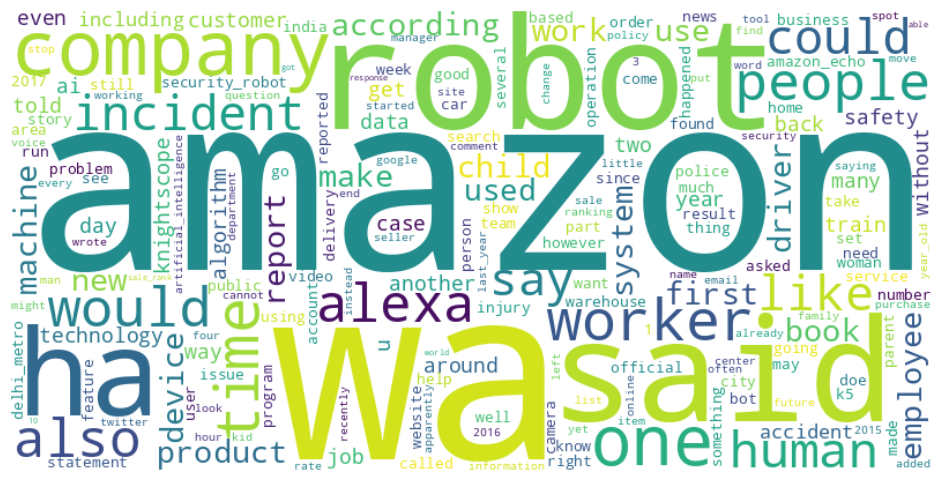

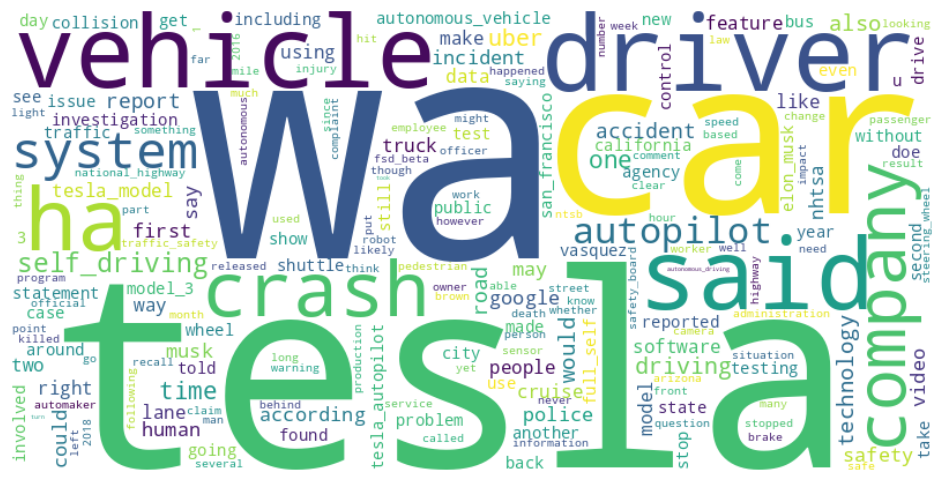

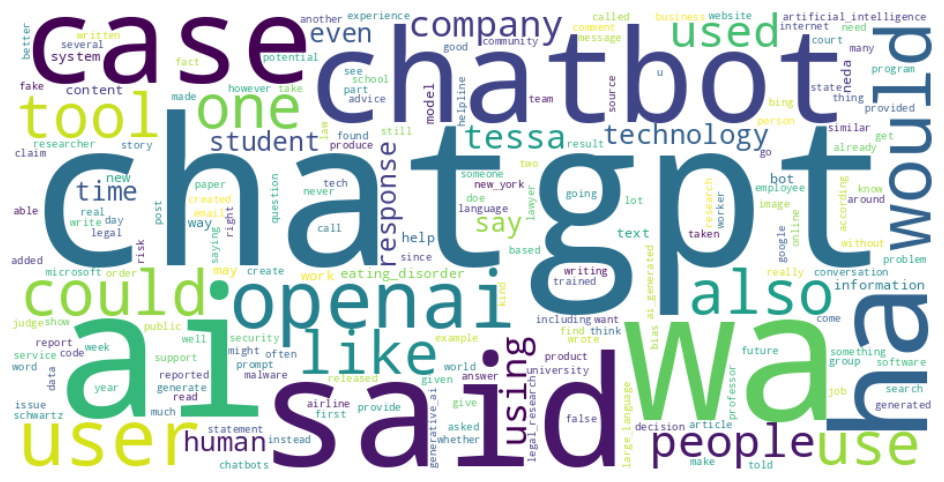

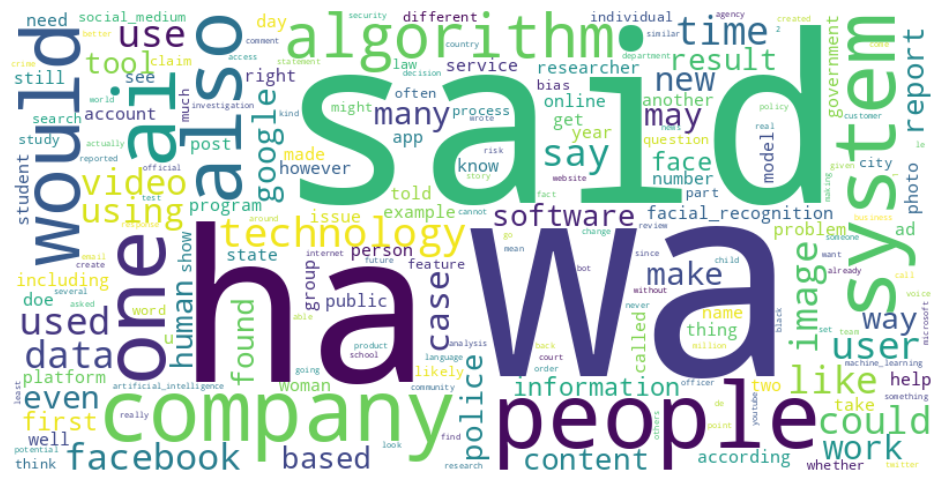

In [ ]:
from numpy import unique
for i in unique(reports["cluster"]):
    visualize_clean_review(reports[reports["cluster"]==i])
# visualize_clean_review(reports[reports["cluster"]==0])
# visualize_clean_review(reports[reports["cluster"]==1])
# visualize_clean_review(reports[reports["cluster"]==2])
# visualize_clean_review(reports[reports["cluster"]==3])

# __Incidents Dataset Labeling__

In [85]:
incidents.head(1)

_id  incident_id        date  \
0  ObjectId(625763de343edc875fe63a15)           23  2017-11-08   

                                             reports  \
0  [242,243,244,245,246,247,248,249,250,253,254,2...   

      Alleged deployer of AI system    Alleged developer of AI system  \
0  ["navya","keolis-north-america"]  ["navya","keolis-north-america"]   

             Alleged harmed or nearly harmed parties  \
0  ["navya","keolis-north-america","bus-passengers"]   

                                         description  \
0  A self-driving public shuttle by Keolis North ...   

                                             title  
0  Las Vegas Self-Driving Bus Involved in Accident

In [86]:
incidents.drop(columns=["_id","date","Alleged deployer of AI system","Alleged developer of AI system","Alleged harmed or nearly harmed parties"], inplace=True)

In [87]:
incidents.head(1)

incident_id                                            reports  \
0           23  [242,243,244,245,246,247,248,249,250,253,254,2...   

                                         description  \
0  A self-driving public shuttle by Keolis North ...   

                                             title  
0  Las Vegas Self-Driving Bus Involved in Accident

In [88]:
missing_values = incidents.isnull().sum()
print("Missing values in each column: \n", missing_values)

Missing values in each column: 
 incident_id    0
reports        0
description    0
title          0
dtype: int64


In [89]:
incidents['clean_review'] = incidents['description'].apply(prepare_data)

incidents.head(5)

C:\Users\34649\AppData\Local\Temp\ipykernel_2648\3342570128.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'lxml').get_text()


incident_id                                            reports  \
0           23  [242,243,244,245,246,247,248,249,250,253,254,2...   
1            4  [629,630,631,632,633,634,635,636,637,638,639,6...   
2            1                 [1,2,3,4,5,6,7,8,9,10,11,12,14,15]   
3           18    [130,131,132,133,134,135,136,137,138,1367,1368]   
4           12                                               [42]   

                                         description  \
0  A self-driving public shuttle by Keolis North ...   
1  An Uber autonomous vehicle (AV) in autonomous ...   
2  YouTube’s content filtering and recommendation...   
3  Google Image returns results that under-repres...   
4  Researchers from Boston University and Microso...   

                                               title  \
0    Las Vegas Self-Driving Bus Involved in Accident   
1               Uber AV Killed Pedestrian in Arizona   
2  Google’s YouTube Kids App Presents Inappropria...   
3               Gender Biases of Google Image Search   
4                 Common Biases of Vector Embeddings   

                                        clean_review  
0  [self, driving, public, shuttle, keolis, north...  
1  [uber, autonomous, vehicle, av, autonomous, mo...  
2  [youtube, content, filtering, recommendation, ...  
3  [google, image, return, result, represent, wom...  
4  [researcher, boston, university, microsoft, re...

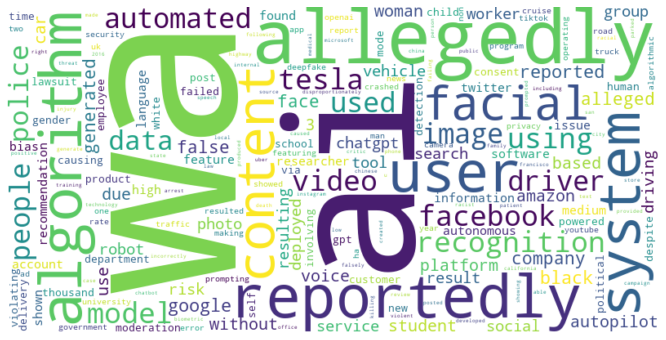

In [90]:
visualize_clean_review(incidents)

In [91]:
corpus_inc = []
for review in incidents['clean_review']:
  corpus_inc.append(review)

print('Number of documents in corpus: '+str(len(corpus_inc)))
print('\n============= First review =============')
print(corpus_inc[0])

Number of documents in corpus: 556

============= First review =============
['self', 'driving', 'public', 'shuttle', 'keolis', 'north', 'america', 'navya', 'wa', 'involved', 'collision', 'human', 'driven', 'delivery', 'truck', 'la', 'vega', 'nevada', 'first', 'day', 'service']


In [92]:
from gensim.models.phrases import Phrases
phrase_model = Phrases(corpus_inc, min_count=2, threshold=20)

print('\n============= First review in corpus =============')
print(corpus_inc[0])
corpus_inc = [el for el in phrase_model[corpus_inc]] # We populate corpus again
print('\n============= First review after N-gram replacement =============')
print(corpus_inc[0])


============= First review in corpus =============
['self', 'driving', 'public', 'shuttle', 'keolis', 'north', 'america', 'navya', 'wa', 'involved', 'collision', 'human', 'driven', 'delivery', 'truck', 'la', 'vega', 'nevada', 'first', 'day', 'service']

============= First review after N-gram replacement =============
['self_driving', 'public', 'shuttle', 'keolis', 'north', 'america', 'navya', 'wa_involved', 'collision', 'human', 'driven', 'delivery', 'truck', 'la', 'vega', 'nevada', 'first', 'day', 'service']


In [93]:
incidents['clean_review'] = corpus_inc

with open("lemmas_clean_inc.txt", 'w', encoding='utf-8') as fout:
  for el in incidents['clean_review'].values.tolist():
    fout.write(' '.join(el) + '\n')

incidents.head(2)

incident_id                                            reports  \
0           23  [242,243,244,245,246,247,248,249,250,253,254,2...   
1            4  [629,630,631,632,633,634,635,636,637,638,639,6...   

                                         description  \
0  A self-driving public shuttle by Keolis North ...   
1  An Uber autonomous vehicle (AV) in autonomous ...   

                                             title  \
0  Las Vegas Self-Driving Bus Involved in Accident   
1             Uber AV Killed Pedestrian in Arizona   

                                        clean_review  
0  [self_driving, public, shuttle, keolis, north,...  
1  [uber, autonomous_vehicle, av, autonomous_mode...

Create Dictionary:

In [94]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus_inc)
n_tokens = len(D)

print('The positive dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The positive dictionary contains 3819 terms
First terms in the dictionary:
0 : america
1 : collision
2 : day
3 : delivery
4 : driven
5 : first
6 : human
7 : keolis
8 : la
9 : navya


Then, we will create a dataframe with the token word and the total number of occurrences throughout all documents.

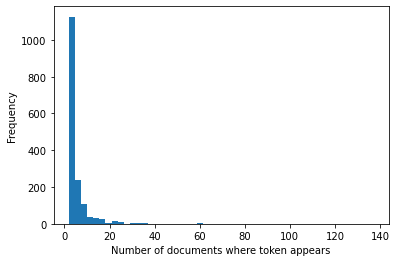

              token  token_id  ndocs
0              anit       120    137
1            kronos       143     90
2             civic      1426     74
3     disadvantaged       139     71
4          doe_meet       274     64
...             ...       ...    ...
1601         vision      1207      2
1602        turkish      1206      2
1603       claiming      1350      2
1604      bing_chat      3342      2
1605     ai_powered       516      2

[1606 rows x 3 columns]


In [95]:
# We create the dataframe
token_counts = pd.DataFrame(D.token2id.items(), columns=['token', 'token_id'])
token_counts['ndocs'] = D.dfs.values()

# We sort in descending order
token_counts = token_counts.sort_values('ndocs', ascending=False).reset_index(drop=True)

# We discard tokens that appear in just one doc
token_counts = token_counts[token_counts.ndocs > 1]

# Define most and least common tokens
most_common_tokens = token_counts.head()
less_common_tokens = token_counts.tail()

# PLot the histogram
plt.hist(token_counts['ndocs'], bins=50)
plt.xlabel('Number of documents where token appears')
plt.ylabel('Frequency')
plt.show()

print(token_counts)

We will now filter out those tokens that have very few appearances and too many appearances, as they are probably not very informative or could be typos.

In [96]:
no_below = 3 # Minimum number of documents to keep a term in the dictionary
no_above = .95 # Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 1016 terms


Once we have our new dictionary, we can proceed with **Bag-Of-Words** representation. To begin with, we will obtain a numerical representation of our corpus and transform any list of tokens into a list of tuples. It can be seen as a vector with tuples (id, n)

In [97]:
reviews_bow = [D.doc2bow(doc) for doc in corpus_inc]

n_review = 5
print('============= Review (lemmas) =============')
print(' '.join(corpus_inc[n_review]))

print('\n============= Sparse vector representation =============')
print(reviews_bow[n_review])

print('\n============= Word counts for the review =============')
print(list(map(lambda x: (D[x[0]], x[1]), reviews_bow[n_review])))

============= Review (lemmas) =============
amazon book store cataloging error led book containing gay lesbian theme lose sale ranking therefore losing visibility sale platform

============= Sparse vector representation =============
[(50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1)]

============= Word counts for the review =============
[('amazon', 1), ('book', 2), ('containing', 1), ('error', 1), ('led', 1), ('platform', 1), ('ranking', 1), ('sale', 2), ('store', 1)]


Furthermore, we can proceed by creating our **TF-IDF model**.

The **TF part** (Term Frequency) measures how frequently each word appears in a document. The **IDF part** (Inverse Document Frequency) measures how rare it is for a word to appear, giving higher scores for words that appear in fewer documents.

In [98]:
from gensim.models import TfidfModel

tfidf = TfidfModel(reviews_bow, dictionary=D)
reviews_tfidf = tfidf[reviews_bow]

In [99]:
n_project = 5
print('============= TFIDF representation for the project =============')
print(reviews_tfidf[n_review])

print('\n============= TFIDF applying the transformation only to the document =============')
print(tfidf[reviews_bow[n_review]])

============= TFIDF representation for the project =============
[(50, 0.1718810506372289), (51, 0.5538579589820581), (52, 0.23141854002808346), (53, 0.22550557332177057), (54, 0.23141854002808346), (55, 0.16976301522847445), (56, 0.27692897949102907), (57, 0.5861481296553849), (58, 0.23802867442289283)]

============= TFIDF applying the transformation only to the document =============
[(50, 0.1718810506372289), (51, 0.5538579589820581), (52, 0.23141854002808346), (53, 0.22550557332177057), (54, 0.23141854002808346), (55, 0.16976301522847445), (56, 0.27692897949102907), (57, 0.5861481296553849), (58, 0.23802867442289283)]


In [100]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(self.__filename, encoding='utf-8'):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()

MyIterCorpus = IterableCorpus_fromfile('lemmas_clean_inc.txt')
newD = Dictionary(MyIterCorpus)
no_below = 3 # Minimum number of documents to keep a term in the dictionary
no_above = .95 # Maximum proportion of documents in which a term can appear to be kept in the dictionary
newD.filter_extremes(no_below=no_below,no_above=no_above)

print('Number of documents processed:', newD.num_docs)
print('Number of elements in dictionary:', len(newD))

Number of documents processed: 556
Number of elements in dictionary: 1016


We will proceed to do the task of **topic modeling** which consists in discovering the underlying themes or topics that exist in the collection of our reviews 's corpus. It is a way of identifying patterns of words that frequently occur together in the text and grouping them into meaningful topics.


In [101]:
from gensim.models import LsiModel

# Initialize an LSI transformation
n_topics = 4

lsi = LsiModel(reviews_tfidf, id2word=D, num_topics=n_topics)
#Display all topics including 10 most relevant tokens per topic
lsi.show_topics(num_topics=-1, num_words=10, log=False, formatted=True)

[(0,
  '0.210*"wa" + 0.166*"user" + 0.161*"ai" + 0.159*"allegedly" + 0.151*"reportedly" + 0.139*"system" + 0.137*"algorithm" + 0.133*"content" + 0.129*"image" + 0.121*"facebook"'),
 (1,
  '0.306*"driver" + 0.247*"tesla_model" + 0.216*"tesla" + 0.213*"car" + 0.191*"vehicle" + 0.179*"autopilot" + 0.176*"road" + 0.155*"highway" + -0.145*"user" + 0.141*"crashed"'),
 (2,
  '0.312*"content" + 0.294*"facebook" + -0.257*"facial_recognition" + 0.188*"user" + -0.135*"arrest" + -0.131*"used" + -0.126*"student" + -0.126*"black_man" + 0.115*"video" + -0.115*"result"'),
 (3,
  '0.302*"image" + 0.197*"ai" + -0.192*"amazon" + -0.166*"product" + -0.162*"facial_recognition" + -0.157*"worker" + -0.156*"system" + 0.146*"model" + -0.141*"robot" + -0.129*"automated"')]

In [102]:
lsi.show_topic(1, topn=10)

[('driver', 0.30602013495619096),
 ('tesla_model', 0.2474432450058013),
 ('tesla', 0.21556357996558154),
 ('car', 0.2132247583744165),
 ('vehicle', 0.19091791900793628),
 ('autopilot', 0.17913522518876598),
 ('road', 0.17641234429425415),
 ('highway', 0.1552103811286071),
 ('user', -0.14461401888004943),
 ('crashed', 0.14087844512771025)]

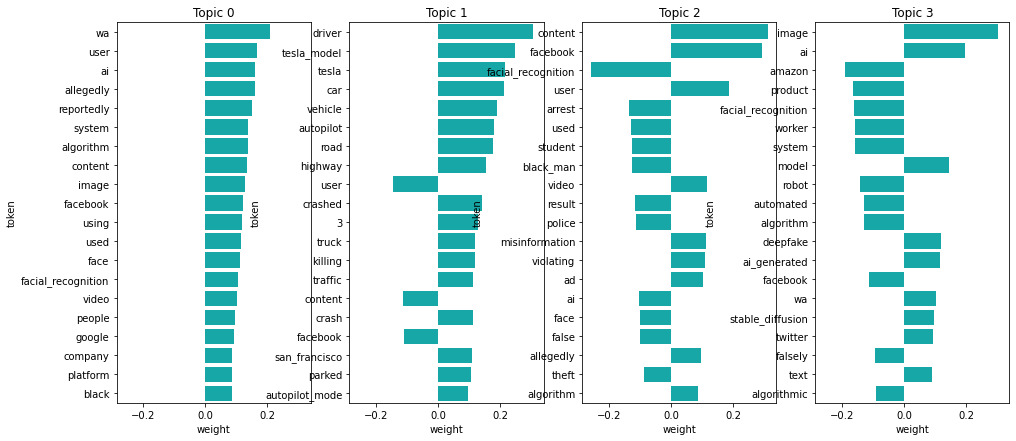

In [103]:
import seaborn as sns

topn = 20

fig, axes = plt.subplots(1, 4, figsize=(16, 7), sharex=True)

for i in range(4):

    df = pd.DataFrame(lsi.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i])
    axes[i].set_title('Topic ' + str(i))

plt.show()

### UNSUPERVISED METHODS
##### CLUSTERING

Adapt out tfidf matrix from gensim, so it can be used in unsupervised algorithms

In [104]:
import gensim
import numpy as np
# Convert Gensim TF-IDF data to a dense NumPy array
dense_tfidf_vectors = [np.array(gensim.matutils.sparse2full(vec, len(tfidf.id2word))) for vec in reviews_tfidf]
tfidf_matrix = np.array(dense_tfidf_vectors)
print(tfidf_matrix.shape)
print(tfidf_matrix[0])

(556, 1016)
[0.31675723 0.25011936 0.29930747 ... 0.         0.         0.        ]


Try different approaches:

In [105]:
clusters = {}

In [106]:
from sklearn.cluster import KMeans

# Apply K-Means clustering to identify clusters
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit_predict(tfidf_matrix)

# Get cluster assignments for each description
kmeans_assignments = kmeans.labels_
clusters["kmeans"]=kmeans_assignments

In [107]:
# # DBSCAN, density-based spatial clustering of applications with noise. It's a density-based clustering algorithm, unlike k-means.
# from sklearn.cluster import DBSCAN

# # define the model
# dbscan = DBSCAN(eps=0.2, min_samples=10)

# # train the model
# dbscan.fit_predict(tfidf_matrix)

# dbscan_assignments = dbscan.labels_
# clusters["dbscan"]=dbscan_assignments

In [108]:
# Gaussian Mixture Models
from sklearn.mixture import GaussianMixture

# define the model
gmm = GaussianMixture(n_components=4)

# train the model
gmm_assignments = gmm.fit_predict(tfidf_matrix)
clusters["gmm"]=gmm_assignments

In [109]:
# Affinity propagation clustering

from sklearn.cluster import AffinityPropagation

# define the model
affinity = AffinityPropagation(damping=0.7)

# train the model
affinity.fit_predict(tfidf_matrix)

affinity_assignments = affinity.labels_
clusters["afinity"]=affinity_assignments

In [110]:
# # OPTICS, Ordering Points to Identify the Clustering Structure
# from sklearn.cluster import OPTICS

# optics_model = OPTICS(eps=0.75, min_samples=10)
# optics_model.fit_predict(tfidf_matrix)
# optics_assignments =optics_model.labels_
# clusters["optics"]=optics_assignments


In [111]:
# Agglomerative Hierarchy clustering algorithm
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=4)
agglomerative.fit_predict(tfidf_matrix)
agglomerative_assignments =agglomerative.labels_
clusters["agglomerative"]=agglomerative_assignments

DIFFERENT PCA APPROACHES DECOMENT AND COMMENT TO TRY DIFFERENT ONE:

In [112]:
from sklearn.decomposition import PCA, KernelPCA

vecs = {}

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_pca = pca_vecs[:, 0]
x1_pca = pca_vecs[:, 1]
vecs["pca"] = [x0_pca,x1_pca]

# KERNEL LINEAR PCA
pca_linear = KernelPCA(n_components=2, kernel='linear' ,random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca_linear.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_linear = pca_vecs[:, 0]
x1_linear = pca_vecs[:, 1]
vecs["linear kernel"] = [x0_linear,x1_linear]

# KERNEL RBF PCA
pca_rbf = KernelPCA(n_components=2, kernel='rbf', random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca_rbf.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_rbf = pca_vecs[:, 0]
x1_rbf = pca_vecs[:, 1]
vecs["rbf kernel"] = [x0_rbf,x1_rbf]

# KERNEL POLY PCA
pca_poly = KernelPCA(n_components=2, kernel='poly',random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca_poly.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_poly = pca_vecs[:, 0]
x1_poly= pca_vecs[:, 1]
vecs["poly kernel"] = [x0_poly,x1_poly]

# KERNEL SIGMOID PCA
pca_sigmoid = KernelPCA(n_components=2, kernel='sigmoid',random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca_sigmoid.fit_transform(tfidf_matrix)
# save our two dimensions into x0 and x1
x0_sigmoid = pca_vecs[:, 0]
x1_sigmoid = pca_vecs[:, 1]
vecs["sigmoid kernel"] = [x0_sigmoid,x1_sigmoid]

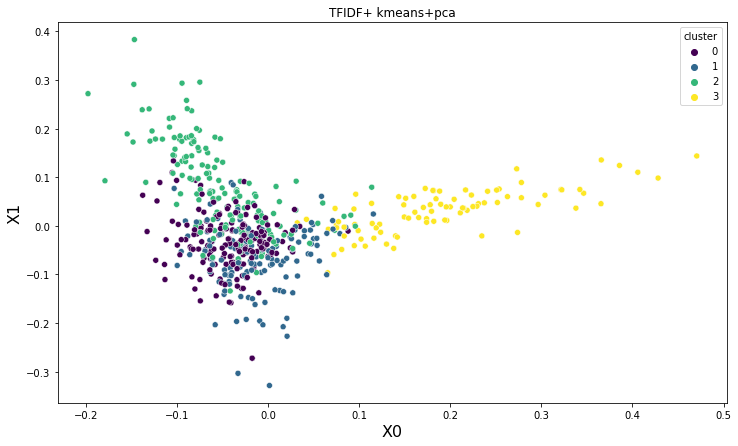

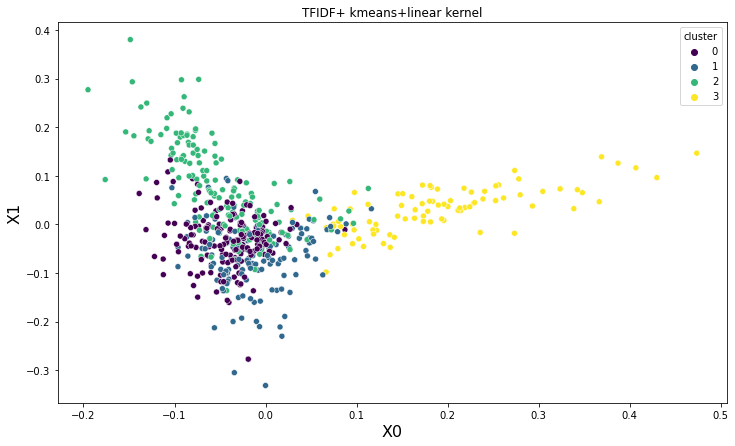

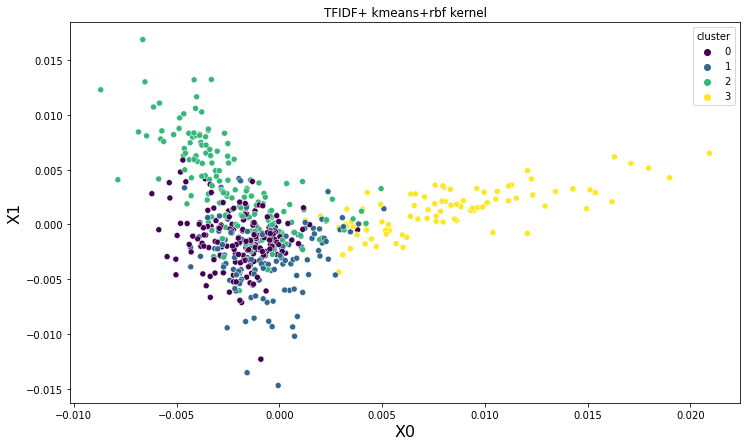

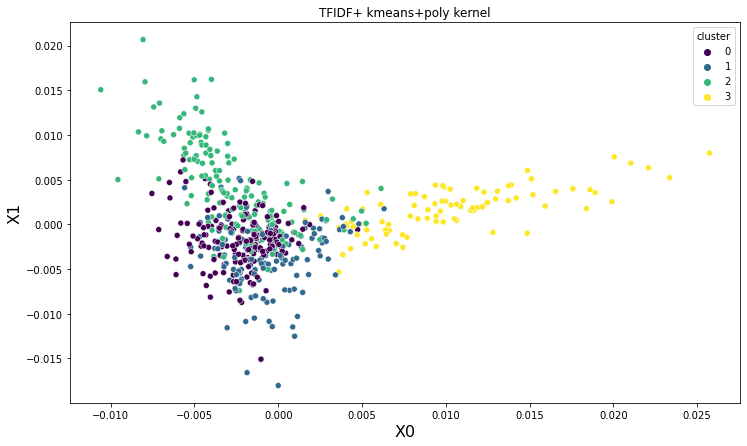

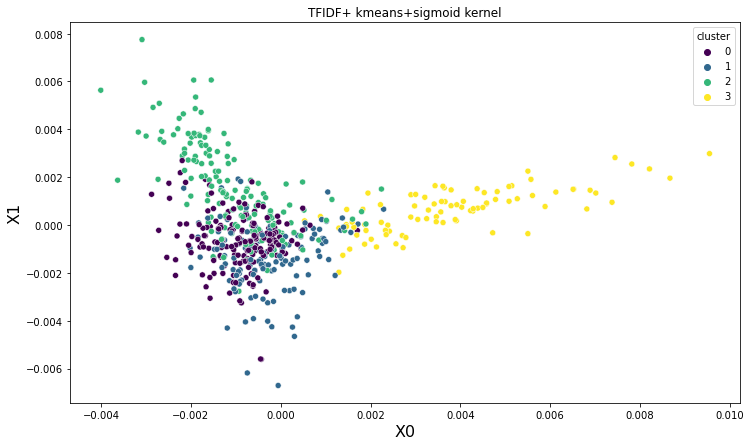

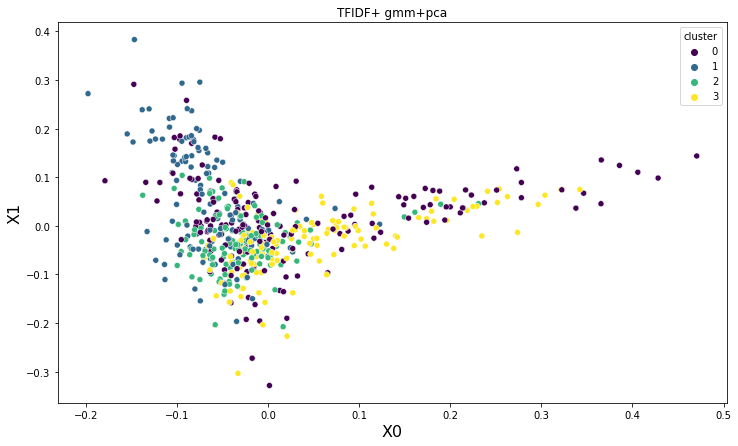

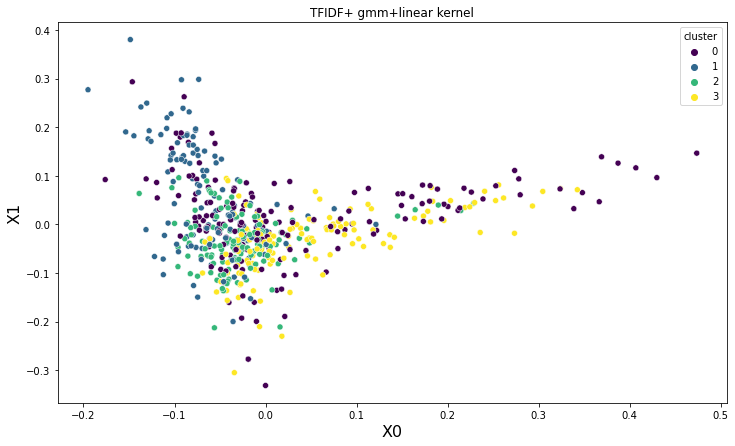

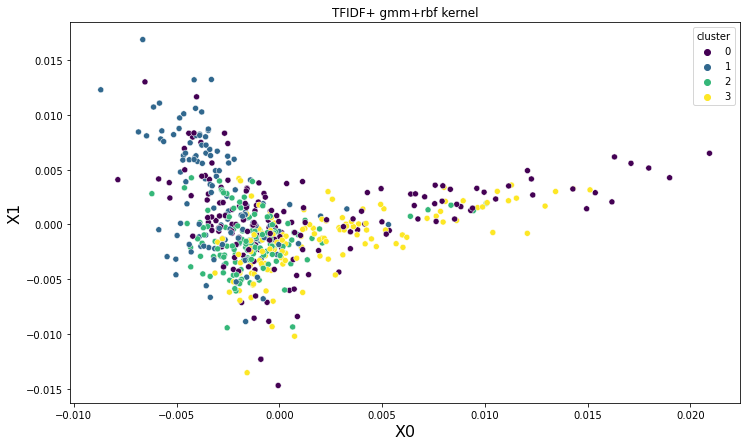

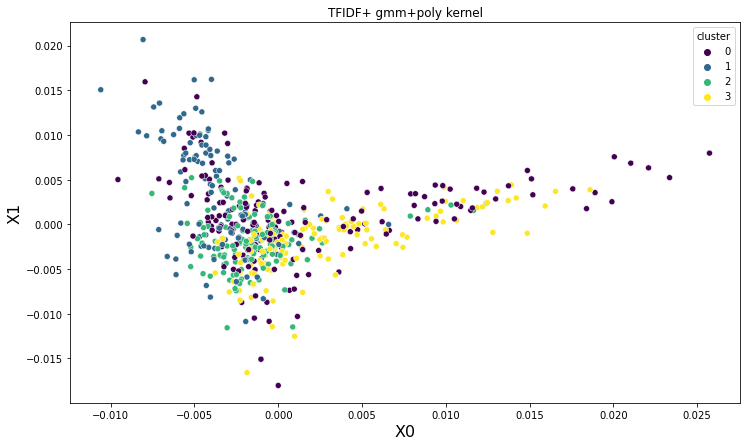

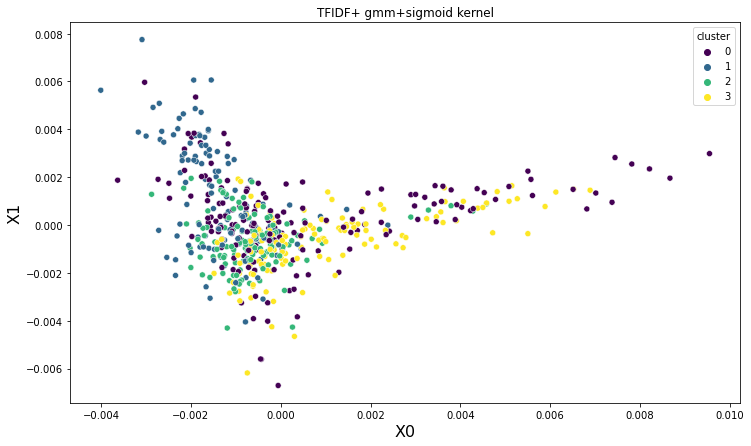

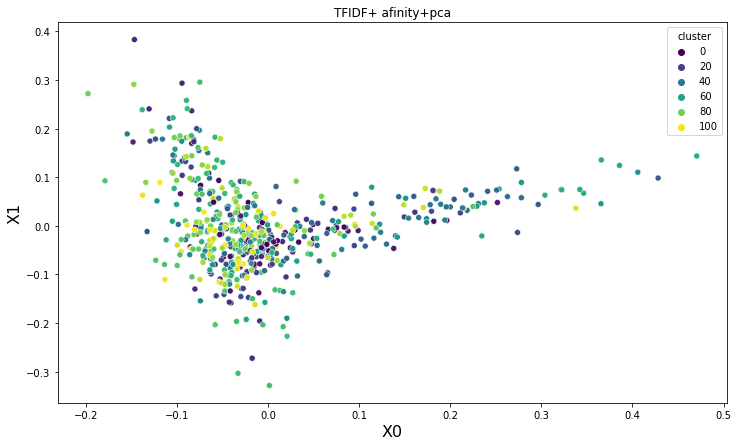

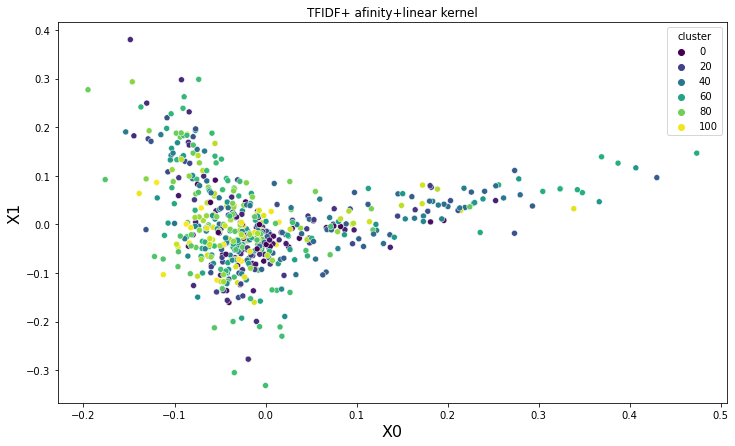

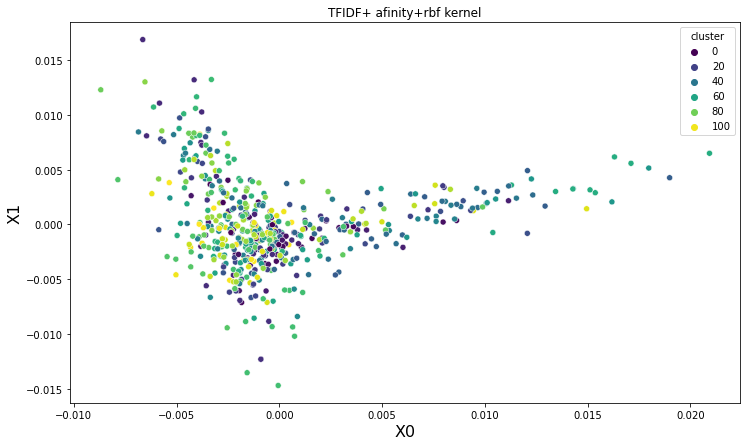

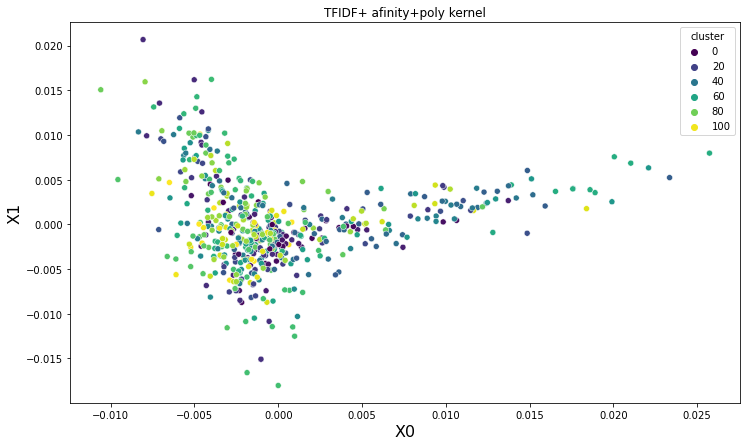

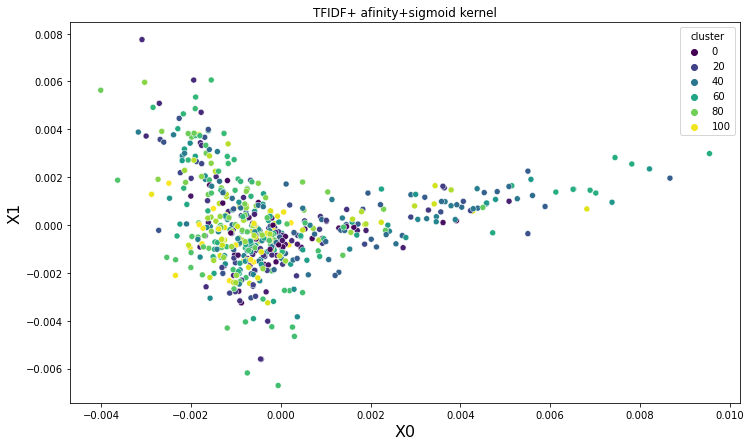

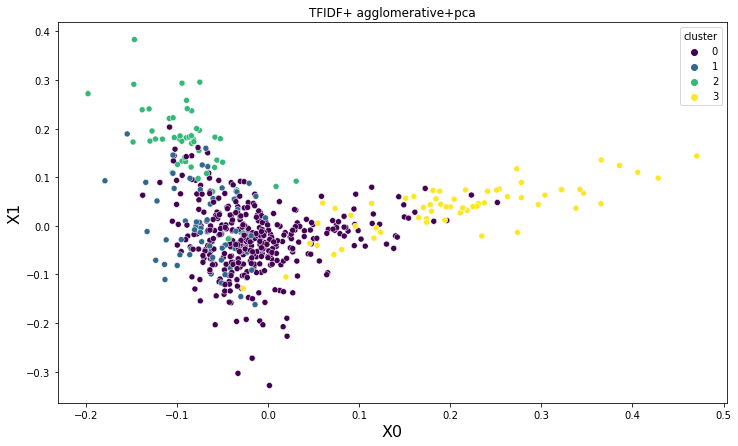

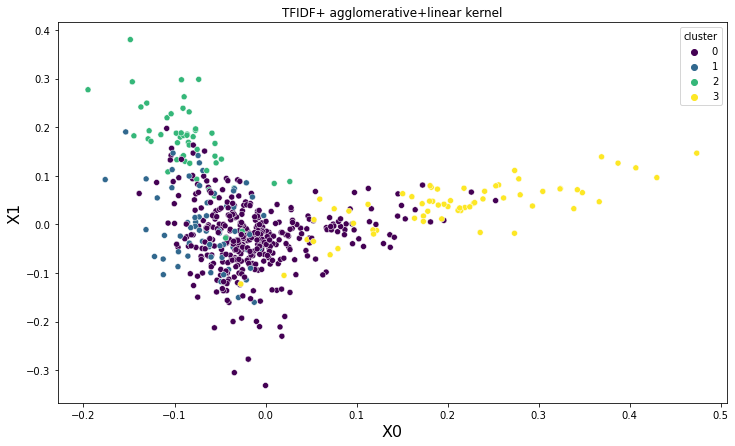

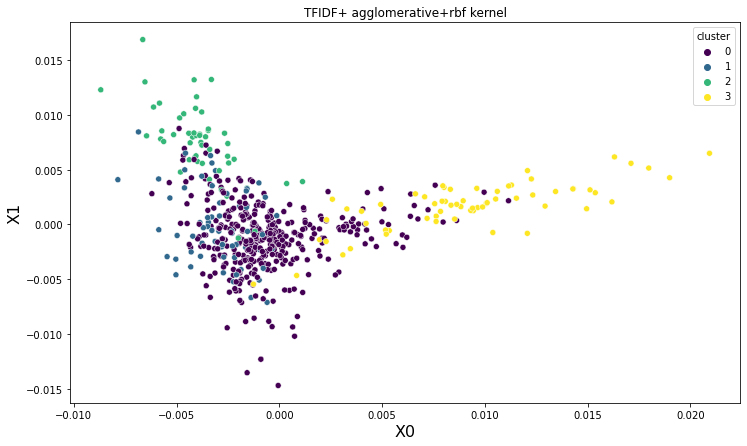

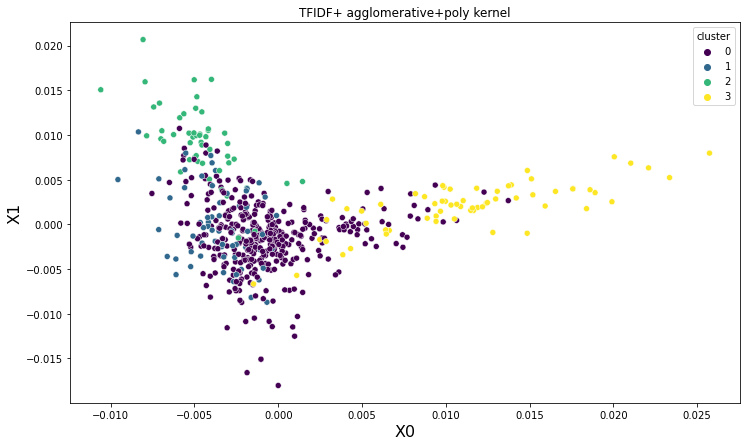

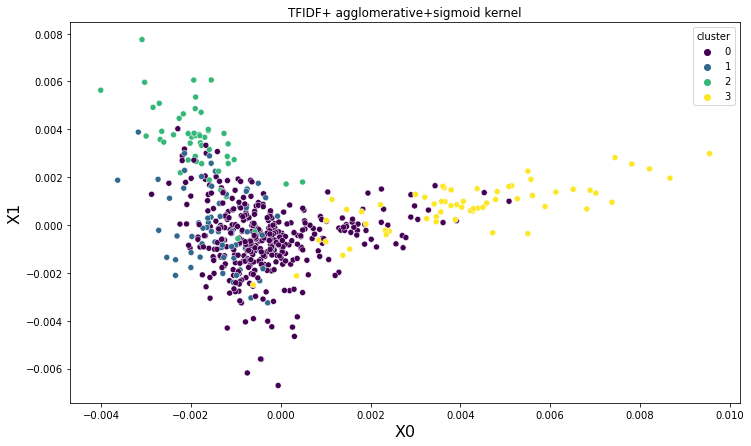

In [113]:
for cluster in clusters.keys():
    for kernel in vecs.keys():

        # assign clusters and pca vectors to our dataframe
        labels = clusters[cluster]
        x0 = vecs[kernel][0]
        x1 = vecs[kernel][1]
        df = pd.DataFrame(list(zip(labels, x0, x1)),
               columns =['cluster', 'x0', 'x1'])
        # set image size
        plt.figure(figsize=(12, 7))
        # set a title
        plt.title(f"TFIDF+ {cluster}+{kernel}")
        # set axes names
        plt.xlabel("X0", fontdict={"fontsize": 16})
        plt.ylabel("X1", fontdict={"fontsize": 16})
        # create scatter plot with seaborn, where hue is the class used to group the data
        sns.scatterplot(data=df, x='x0', y='x1', hue='cluster', palette="viridis")
        plt.show()

In [114]:
labels = clusters["kmeans"]
x0 = vecs["pca"][0]
x1 = vecs["pca"][1]

incidents["cluster"] = labels

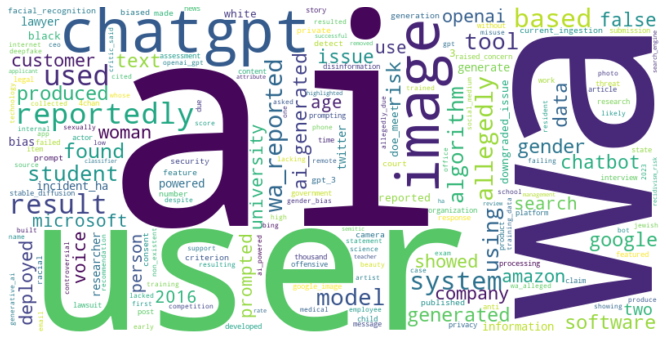

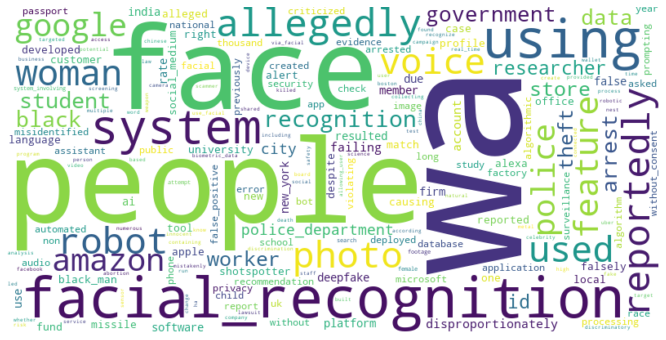

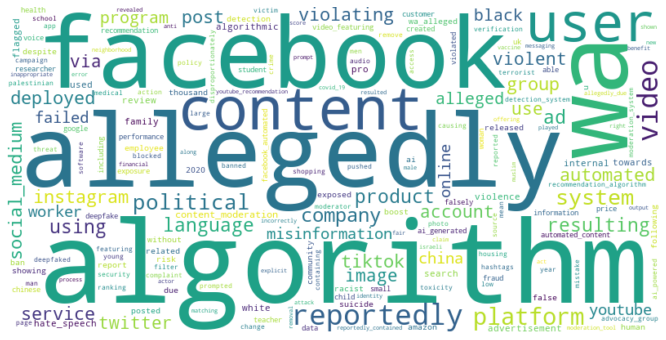

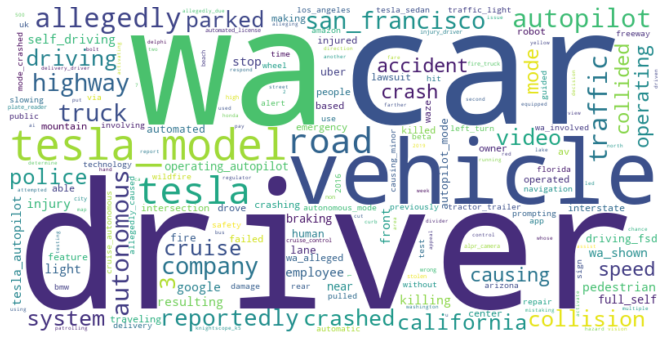

In [115]:
from numpy import unique
for i in unique(incidents["cluster"]):
    visualize_clean_review(incidents[incidents["cluster"]==i])

In [116]:
incidents = incidents.drop(columns=["cluster"])

## LABELING BY TERMS

In [117]:
# Visualize corpus_inc
# i = 0
# for i in range(len(corpus_inc)):
#   print(i, corpus_inc[i])
#   i = i+1

In [122]:
# LABELS:
# 1. SECURITY AND SAFETY
sec_saf = ["self_driving","autonomous_driving","tesla_model","accident", "autonomous_vehicle", "av"]
# 2. SOCIAL HARMS
social = ["biased","harmful","racist", "inappropriate"]

# Add labels
incidents["labels"] = np.nan
for i in range(len(incidents["clean_review"])):
    for w in incidents["clean_review"][i]:
        if w in sec_saf:
            incidents['labels'][i]='SECURITY AND SAFETY'
            print(w)
            print(incidents["clean_review"][i])
        elif w in social:
            incidents['labels'][i]='SOCIAL HARM'
            print(w)
            print(incidents["clean_review"][i])

incidents.head(5)

self_driving
['self_driving', 'public', 'shuttle', 'keolis', 'north', 'america', 'navya', 'wa_involved', 'collision', 'human', 'driven', 'delivery', 'truck', 'la', 'vega', 'nevada', 'first', 'day', 'service']
autonomous_vehicle
['uber', 'autonomous_vehicle', 'av', 'autonomous_mode', 'struck', 'killed', 'pedestrian', 'tempe', 'arizona']
av
['uber', 'autonomous_vehicle', 'av', 'autonomous_mode', 'struck', 'killed', 'pedestrian', 'tempe', 'arizona']
inappropriate
['youtube', 'content', 'filtering', 'recommendation_algorithm', 'exposed', 'child', 'disturbing', 'inappropriate', 'video']
racist
['microsoft', 'tay', 'artificially_intelligent', 'chatbot', 'wa', 'released', 'march', '23', '2016', 'removed', 'within', '24', 'hour', 'due', 'multiple', 'racist', 'sexist', 'anit', 'semitic', 'tweet', 'generated', 'bot']
accident
['multiple', 'unrelated', 'car', 'accident', 'result', 'varying', 'level', 'harm', 'occurred', 'tesla_autopilot', 'wa', 'use']
racist
['google', 'cloud', 'natural', 'langua

C:\Users\34649\AppData\Local\Temp\ipykernel_2648\1229371247.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incidents['labels'][i]='SECURITY AND SAFETY'


incident_id                                            reports  \
0           23  [242,243,244,245,246,247,248,249,250,253,254,2...   
1            4  [629,630,631,632,633,634,635,636,637,638,639,6...   
2            1                 [1,2,3,4,5,6,7,8,9,10,11,12,14,15]   
3           18    [130,131,132,133,134,135,136,137,138,1367,1368]   
4           12                                               [42]   

                                         description  \
0  A self-driving public shuttle by Keolis North ...   
1  An Uber autonomous vehicle (AV) in autonomous ...   
2  YouTube’s content filtering and recommendation...   
3  Google Image returns results that under-repres...   
4  Researchers from Boston University and Microso...   

                                               title  \
0    Las Vegas Self-Driving Bus Involved in Accident   
1               Uber AV Killed Pedestrian in Arizona   
2  Google’s YouTube Kids App Presents Inappropria...   
3               Gender Biases of Google Image Search   
4                 Common Biases of Vector Embeddings   

                                        clean_review               labels  
0  [self_driving, public, shuttle, keolis, north,...  SECURITY AND SAFETY  
1  [uber, autonomous_vehicle, av, autonomous_mode...  SECURITY AND SAFETY  
2  [youtube, content, filtering, recommendation_a...          SOCIAL HARM  
3  [google_image, return, result, represent, woma...                  NaN  
4  [researcher, boston, university, microsoft, re...                  NaN

In [132]:
value_count=incidents['labels'].value_counts()
print(value_count)
print(incidents['labels'].isna().sum())
print(value_count[0]+value_count[1]+incidents['labels'].isna().sum())
print(len(incidents['labels']))

SECURITY AND SAFETY    36
SOCIAL HARM            23
Name: labels, dtype: int64
497
556
556


### ZERO-SHOT CLASSIFICATION: facebook/bart-large-mnli (HUGGING FACE)

In [3]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [ ]:
"""
sequence_to_classify = "one day I will see the world"
candidate_labels = ['travel', 'cooking', 'dancing']
classifier(sequence_to_classify, candidate_labels)
#{'labels': ['travel', 'dancing', 'cooking'],
# 'scores': [0.9938651323318481, 0.0032737774308770895, 0.002861034357920289],
# 'sequence': 'one day I will see the world'}
"""

In [7]:
print(incidents["description"][0])

A self-driving public shuttle by Keolis North America and Navya was involved in a collision with a human-driven delivery truck in Las Vegas, Nevada on its first day of service.


In [10]:
sequence_to_classify = incidents["description"][0]
candidate_labels = ['safety error', 'social harm', 'security']
classifier(sequence_to_classify, candidate_labels, multi_label=True)

{'sequence': 'A self-driving public shuttle by Keolis North America and Navya was involved in a collision with a human-driven delivery truck in Las Vegas, Nevada on its first day of service.',
 'labels': ['safety error', 'social harm', 'security'],
 'scores': [0.5826309323310852, 0.41109946370124817, 0.09504515677690506]}